In [30]:
import numpy as np
from numpy import linalg as LA
import math 

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from scipy import spatial
from scipy.spatial import KDTree
from scipy.spatial import Delaunay

from shapely.geometry import Polygon

#change trigonometric functions name
pi = np.pi
cos = np.cos
sin = np.sin
arccos = np.arccos

In [68]:
#User parameters

r=15 #radius of sphere
z_point=20#pinhole position
z_plane=z_point+20 #sensor position


# Create a sphere of 15 mm and distribute equally distanced points
r = 15 #mm

#https://web.archive.org/web/20120107030109/http://cgafaq.info/wiki/Evenly_distributed_points_on_sphere#Spirals
# alternative--> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3223966/#APP1

N=3000
dlong= np.pi*(3-np.sqrt(5)) # /* ~2.39996323 */
dz= 2.0/N
long= 0
z= 1 - dz/2
node=[]

for k in range(N):
    R = np.sqrt(1-z*z)
    node.append((cos(long)*R, sin(long)*R, z))
    z = z - dz
    long= long + dlong
    
node=np.array(node)

x0,y0,z0=r*node[:,0],r*node[:,1],r*node[:,2]

# choose only backside of sphere
z_exclude=0

x=np.delete(x0,np.where(z0>z_exclude))
y=np.delete(y0,np.where(z0>z_exclude))
z=np.delete(z0,np.where(z0>z_exclude))



<IPython.core.display.Javascript object>


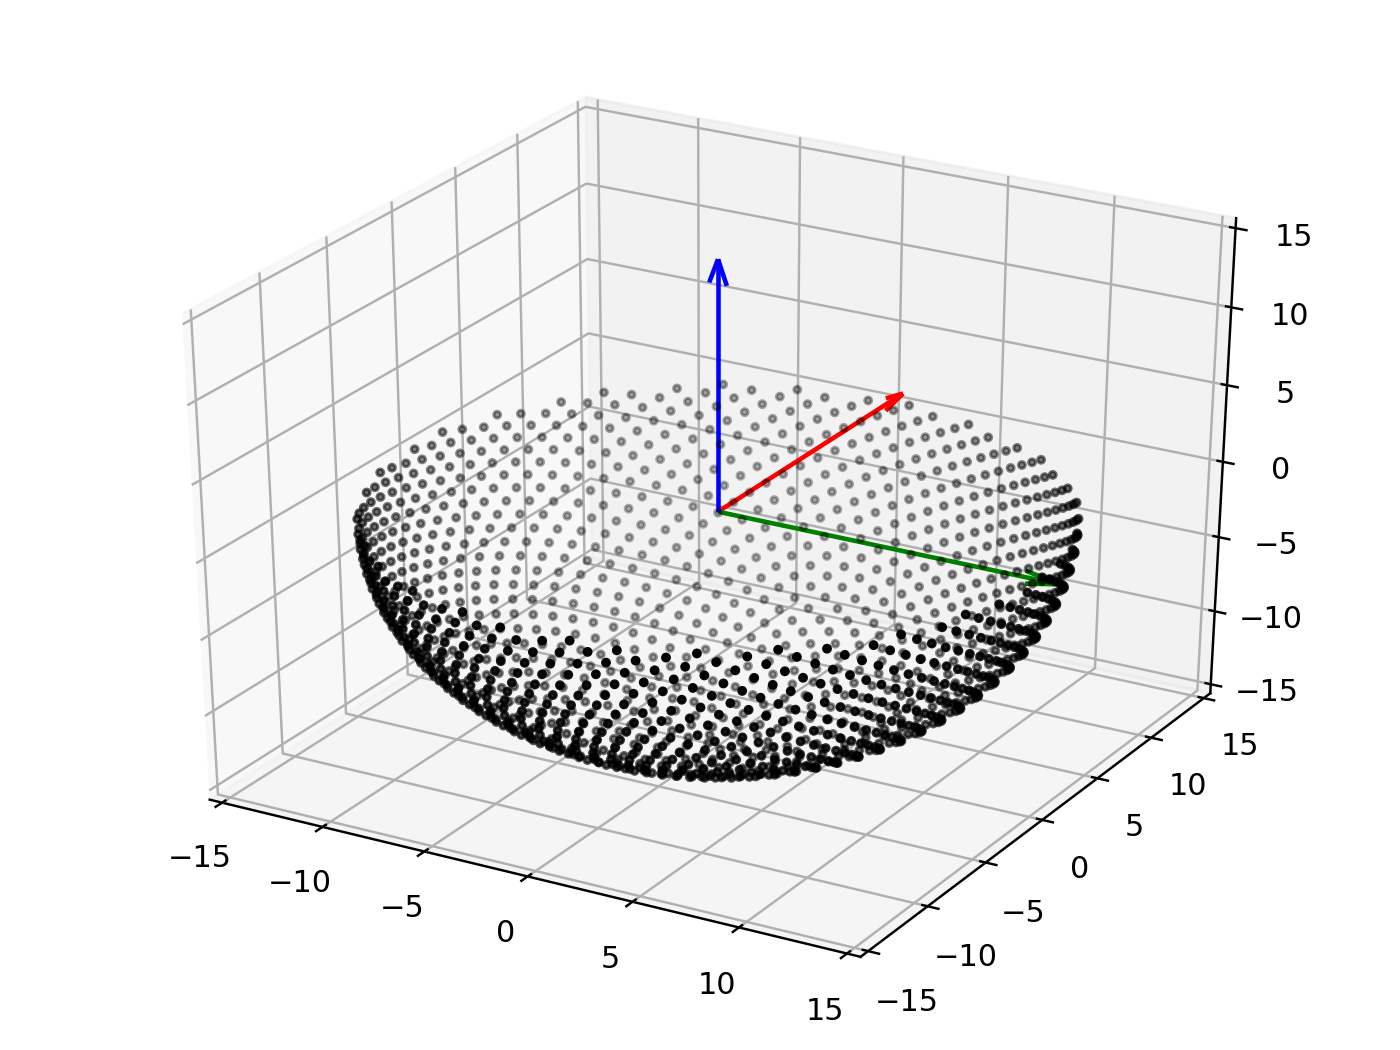

In [69]:
%matplotlib notebook
#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)

ax.quiver(0, 0, 0, 16, 0, 0, arrow_length_ratio=0.1,color="g") #x
ax.quiver(0, 0, 0, 0, 16, 0, arrow_length_ratio=0.1,color="r") #y
ax.quiver(0, 0, 0, 0, 0, 16, arrow_length_ratio=0.1,color="b") #z

ax.scatter(x,y,z,color="k",s=5)

ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_zlim([-15,15])

plt.tight_layout()
#plt.show()

In [70]:
#compute intersection as in https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection
f_point=[0,0,z_point]
plane_origin=[0,0,z_plane]
plane_normal=[0,0,1]

d=np.dot(plane_normal,plane_origin)
x_c=[]
y_c=[]
z_c=[]
line=[]

for i in range(len(x)):
    O=[x[i],y[i],z[i]]
    ray=-(np.array(O)-np.array(f_point))
    ray=ray/np.linalg.norm(ray)
    t=(d-np.dot(plane_normal,O))/np.dot(plane_normal,ray)
    new_ray=ray*t
    contact=O+new_ray
    x_c.append(contact[0])
    y_c.append(contact[1])
    z_c.append(contact[2])
    line.append(new_ray)

line=np.array(line)

In [71]:
line.shape

(1500, 3)

<IPython.core.display.Javascript object>


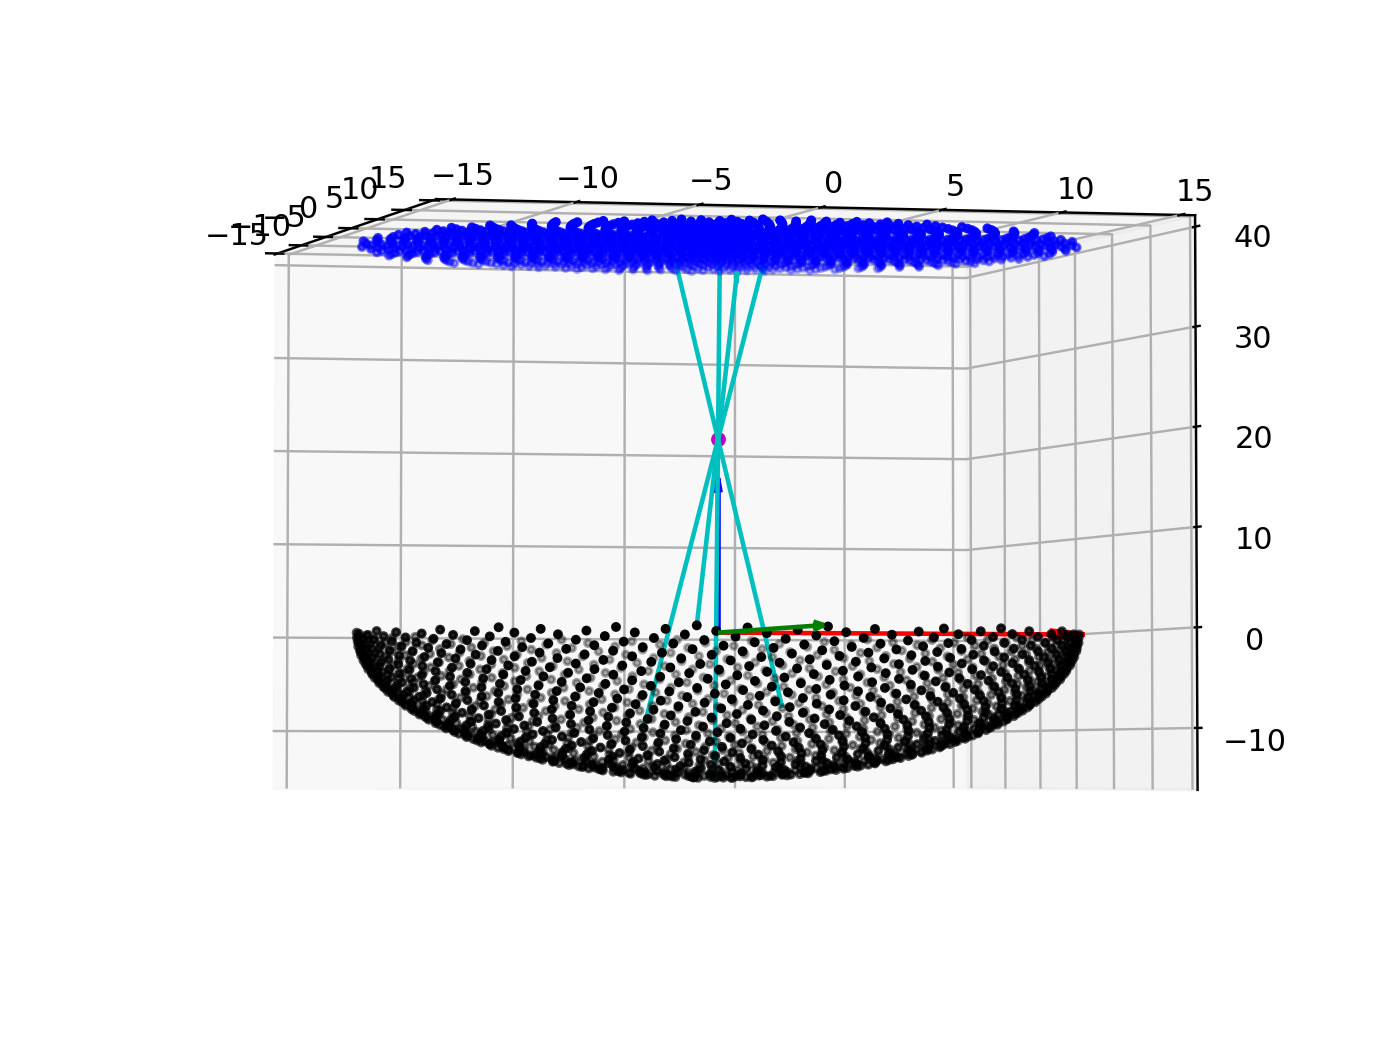

In [72]:
%matplotlib notebook
#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)

ax.quiver(0, 0, 0, 16, 0, 0, arrow_length_ratio=0.1,color="g") #x
ax.quiver(0, 0, 0, 0, 16, 0, arrow_length_ratio=0.1,color="r") #y
ax.quiver(0, 0, 0, 0, 0, 16, arrow_length_ratio=0.1,color="b") #z

ax.scatter(x,y,z,color="k",s=5)
ax.scatter(x_c,y_c,z_c,color="b",s=5)
ax.scatter(f_point[0],f_point[1],f_point[2],color="m",s=15)

ax.quiver(x[0],y[0],z[0], line[0,0], line[0,1], line[0,2], arrow_length_ratio=0.03,color="c") #z
ax.quiver(x[int(N/4)],y[int(N/4)],z[int(N/4)], line[int(N/4),0], line[int(N/4),1], line[int(N/4),2], arrow_length_ratio=0.03,color="c") #z
ax.quiver(x[int(N/3)],y[int(N/3)],z[int(N/3)], line[int(N/3),0], line[int(N/3),1], line[int(N/3),2], arrow_length_ratio=0.03,color="c") #z
ax.quiver(x[int(N/2-1)],y[int(N/2-1)],z[int(N/2-1)], line[int(N/2-1),0], line[int(N/2-1),1], line[int(N/2-1),2], arrow_length_ratio=0.03,color="c") #z

ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_zlim([-15,z_plane])

plt.tight_layout()
#plt.show()

<IPython.core.display.Javascript object>


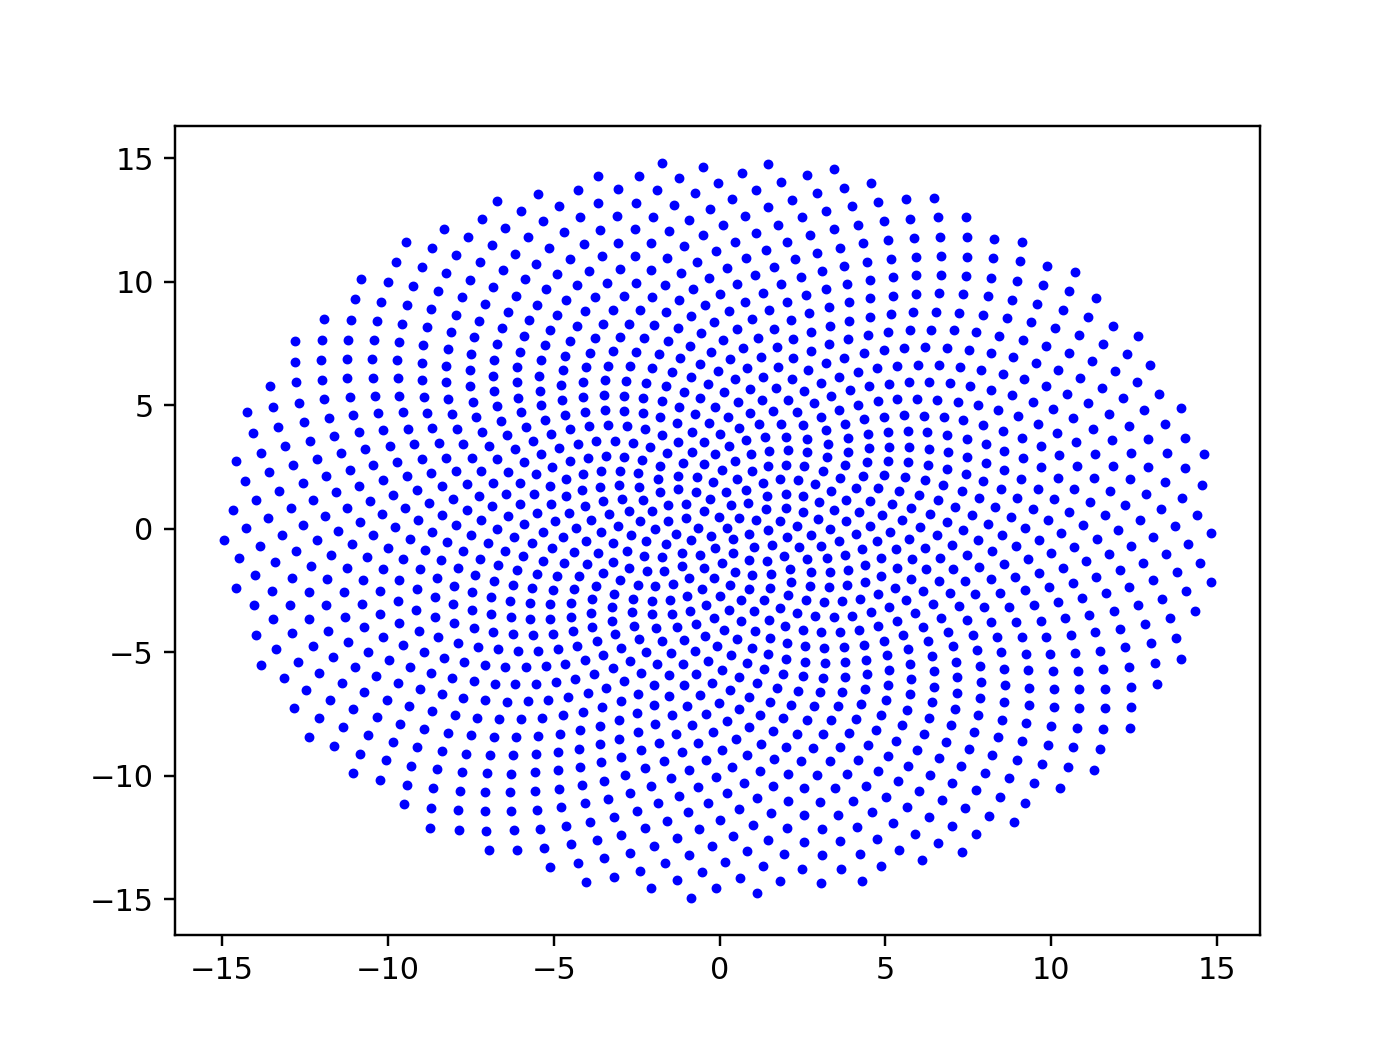

In [73]:
#plot sensor points

%matplotlib notebook
fig = plt.figure()
plt.scatter(x_c,y_c,color="b",s=5)

<IPython.core.display.Javascript object>


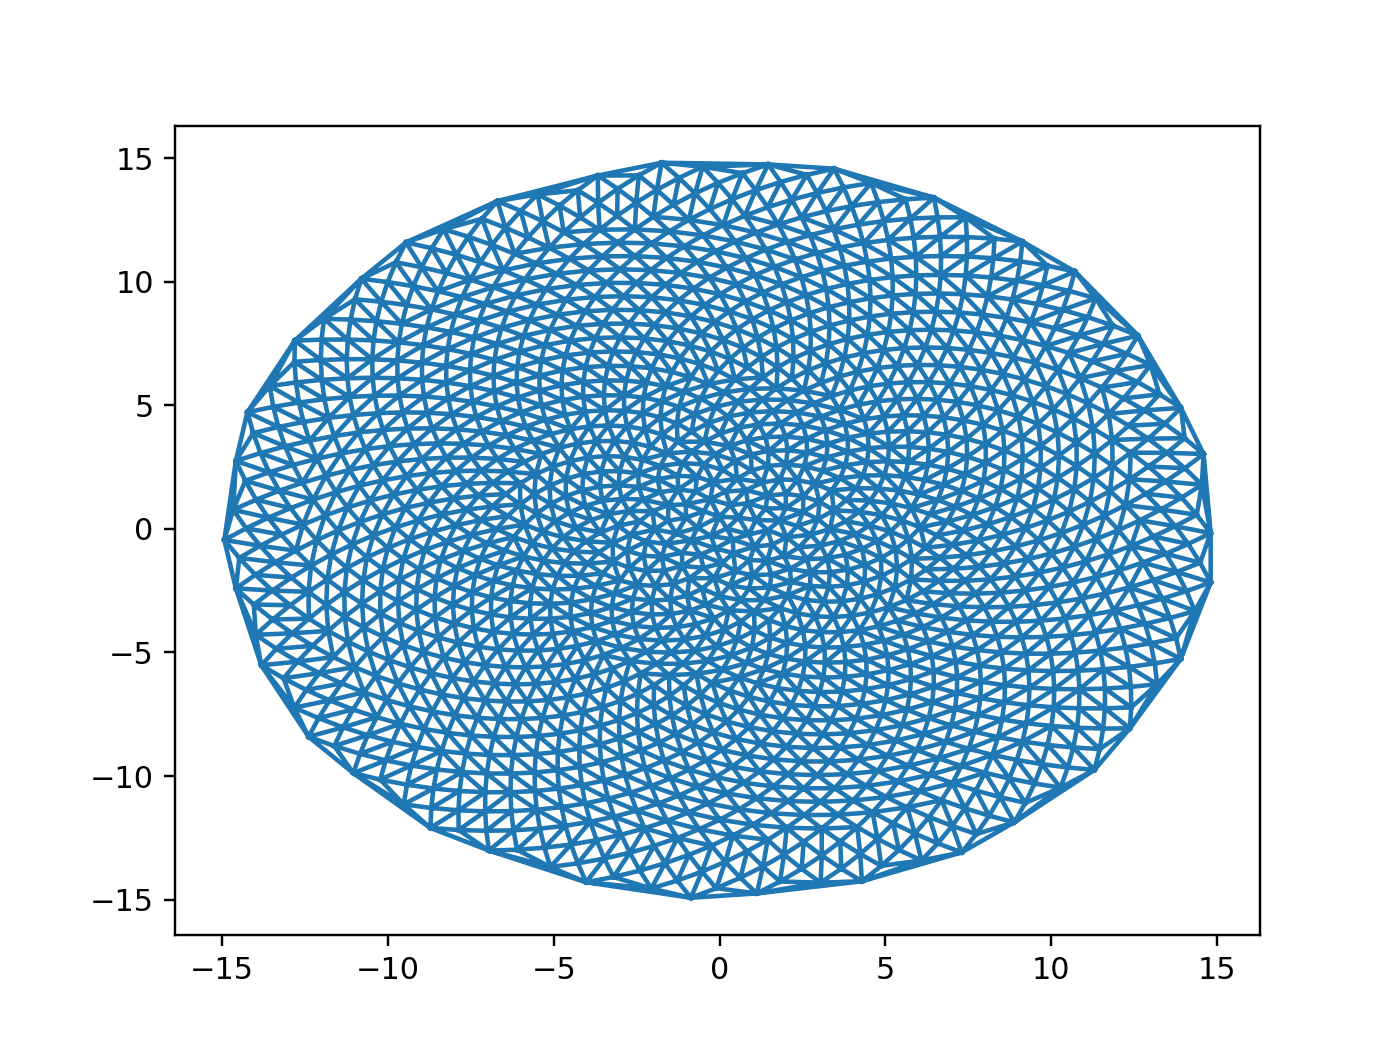

In [74]:
#triangulate points 

points=[]
for i in range (len(x_c)):
    points.append([x_c[i],y_c[i]])
    
points=np.array(points)    
#tree = KDTree(points)    
tri = Delaunay(points)

points_sphere=[]
for i in range (len(x)):
    points_sphere.append([x[i],y[i],z[i]])  
points_sphere=np.array(points_sphere)  
tri_sph = Delaunay(points_sphere)

%matplotlib notebook

fig = plt.figure()
plt.triplot(points[:,0], points[:,1], tri.simplices)


<IPython.core.display.Javascript object>


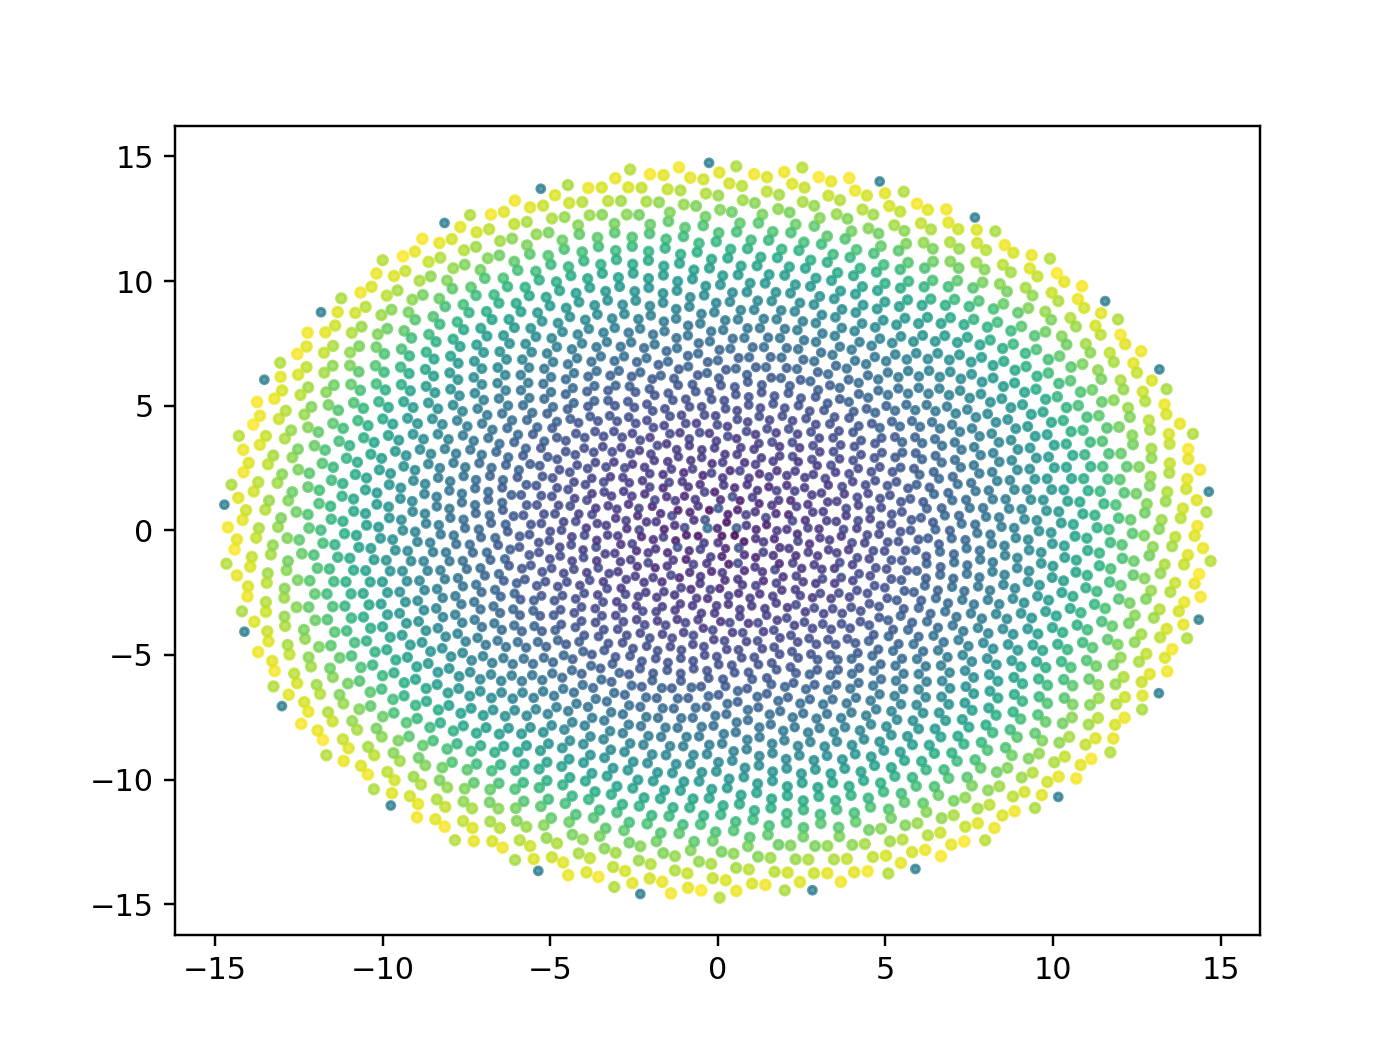

In [75]:
#compute triangles area

def PolyArea(x,y):
    area= 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    return area

A=[]
C=[]

for s in range(len(tri.simplices)):
    c=tri.simplices[s]
    p=[]    
    for i in range(3):
        p.append(points[c[i]])
    p=np.array(p)
    #A.append(PolyArea(p[:,0],p[:,1]))
    polygon = Polygon(p)
    A.append(polygon.area)
    centroid = (sum(p[:,0] / len(p[:,0])), sum(p[:,1] / len(p[:,1])))
    C.append(centroid)
        

C=np.array(C)
A=np.array(A)

fig = plt.figure()      
plt.scatter(C[:,0],C[:,1],c=A, s=A*30, cmap='viridis', alpha=0.75)

